[*********************100%***********************]  1 of 1 completed


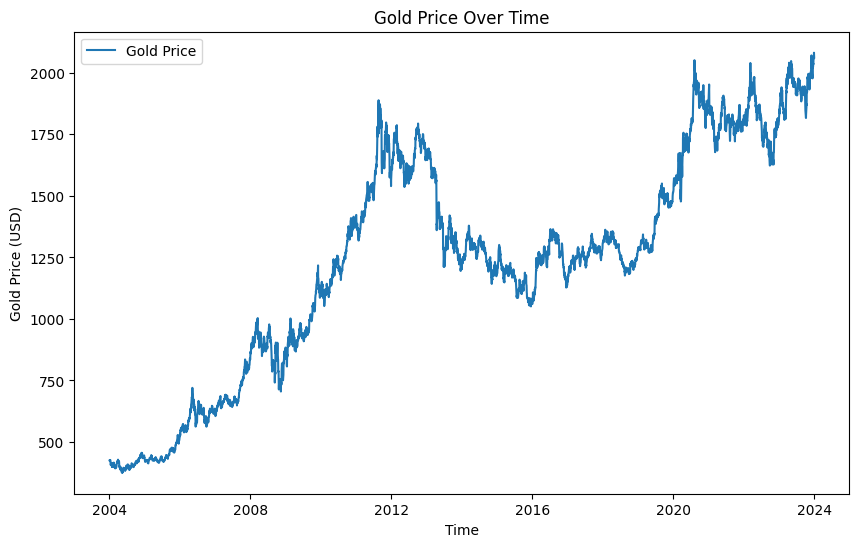

/home/knuggets/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.0161 - val_loss: 0.0011
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 3.3822e-04 - val_loss: 0.0010
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 3.3493e-04 - val_loss: 6.7768e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 2.9714e-04 - val_loss: 9.4554e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 3.3775e-04 - val_loss: 5.8750e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 2.7684e-04 - val_loss: 6.4033e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 2.7815e-04 - val_loss: 6.5414e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 2.6556e-04 - val_loss: 5.4800e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 2.4098e-04 - val_loss: 6.3781e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - loss: 2.5333e-04 - val_loss: 0.0014
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s

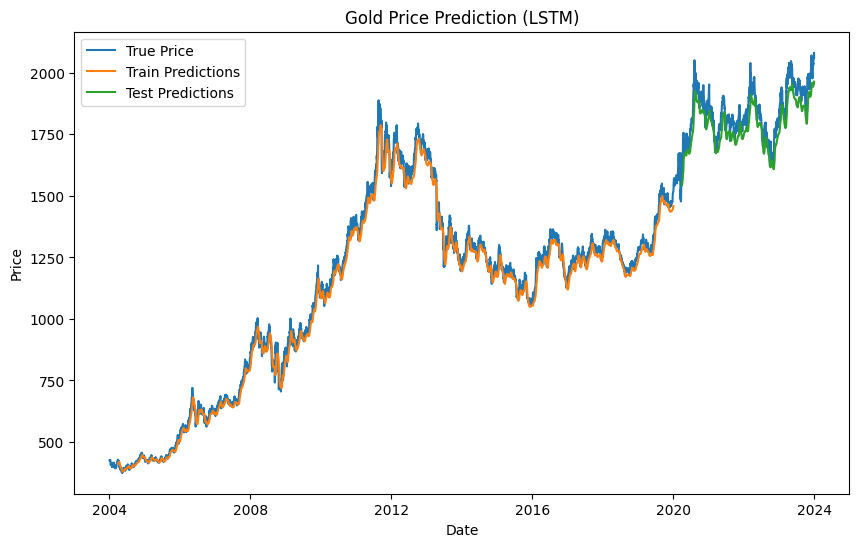

LSTM RMSE: 64.28050517521461


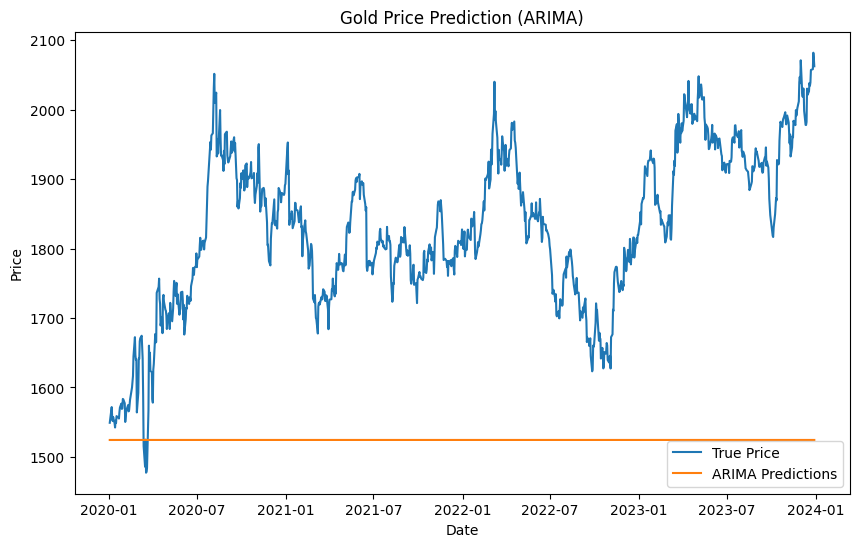

ARIMA RMSE: 324.5209666220121


ValueError: operands could not be broadcast together with shapes (944,) (1005,) 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA

# Download gold price data from Yahoo Finance (past 20 years)
data = yf.download('GC=F', start='2004-01-01', end='2024-01-01')
data = data[['Close']].dropna()  # Use the 'Close' price and remove NaN values

# Plot the closing prices
plt.figure(figsize=(10,6))
plt.plot(data['Close'], label='Gold Price')
plt.title('Gold Price Over Time')
plt.xlabel('Time')
plt.ylabel('Gold Price (USD)')
plt.legend()
plt.show()

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create dataset for supervised learning
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Split into training and test sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create datasets
time_step = 60  # Number of previous days to look at
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse scaling to get original values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Plot results
plt.figure(figsize=(10,6))
plt.plot(data.index, data['Close'], label='True Price')
train_predictions_plot = np.empty_like(scaled_data)
train_predictions_plot[:, :] = np.nan
train_predictions_plot[time_step:len(train_predict) + time_step, :] = train_predict
plt.plot(data.index[:train_size], train_predictions_plot[:train_size], label='Train Predictions')

test_predictions_plot = np.empty_like(scaled_data)
test_predictions_plot[:, :] = np.nan
test_predictions_plot[len(train_predict) + (time_step*2)+1:len(scaled_data)-1, :] = test_predict
plt.plot(data.index[len(train_predict) + (time_step*2)+1:len(scaled_data)-1], test_predictions_plot[len(train_predict) + (time_step*2)+1:len(scaled_data)-1], label='Test Predictions')

plt.title('Gold Price Prediction (LSTM)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate RMSE for LSTM
lstm_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f"LSTM RMSE: {lstm_rmse}")

# ----- ARIMA Model for Comparison -----
# Use raw close prices for ARIMA
gold_prices = data['Close'].values
train_arima = gold_prices[:train_size]
test_arima = gold_prices[train_size:]

# ARIMA model fitting
arima_model = ARIMA(train_arima, order=(5,1,0))
arima_model_fit = arima_model.fit()

# Make predictions
arima_predictions = arima_model_fit.forecast(steps=len(test_arima))
plt.figure(figsize=(10,6))
plt.plot(data.index[len(train_arima):], test_arima, label='True Price')
plt.plot(data.index[len(train_arima):], arima_predictions, label='ARIMA Predictions')
plt.title('Gold Price Prediction (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate RMSE for ARIMA
arima_rmse = np.sqrt(mean_squared_error(test_arima, arima_predictions))
print(f"ARIMA RMSE: {arima_rmse}")

# ----- Hybrid Model (LSTM + ARIMA) -----
# Combine LSTM and ARIMA results
hybrid_predictions = (test_predict[:, 0] + arima_predictions) / 2

plt.figure(figsize=(10,6))
plt.plot(data.index[len(train_predict) + (time_step*2)+1:len(scaled_data)-1], test_predict[:, 0], label='LSTM')
plt.plot(data.index[len(train_arima):], arima_predictions, label='ARIMA')
plt.plot(data.index[len(train_predict) + (time_step*2)+1:len(scaled_data)-1], hybrid_predictions, label='Hybrid')
plt.title('Gold Price Prediction (Hybrid Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate RMSE for Hybrid Model
hybrid_rmse = np.sqrt(mean_squared_error(y_test[0], hybrid_predictions))
print(f"Hybrid RMSE: {hybrid_rmse}")

# ----- Predicting Future Gold Prices -----
future_days = 30  # Predict for next 30 days using LSTM
future_input = scaled_data[len(scaled_data)-time_step:].reshape(1, -1)
temp_input = list(future_input[0])

future_preds = []
for i in range(future_days):
    future_data = np.array(temp_input[len(temp_input)-time_step:]).reshape(1, time_step, 1)
    future_pred = model.predict(future_data)
    future_preds.append(scaler.inverse_transform(future_pred)[0][0])
    temp_input.append(future_pred[0][0])

# Plot future predictions
plt.figure(figsize=(10,6))
plt.plot(range(future_days), future_preds, label='Predicted Future Prices')
plt.title('Gold Price Prediction for Next 30 Days (LSTM)')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
